# Oily Giant

Trabajamos para la compañía minera OilyGiant. El objetivo es encontrar el mejor lugar para un nuevo pozo utilizando los siguientes pasos para elegir la ubicación:

    * Recolectar los parámetros del pozo de petróleo en la región seleccionada: calidad del petróleo y volumen de reservas
    * Construir un modelo para predecir el volumen de reservas en los nuevos pozos
    * Seleccionar los pozos de petróleo con los valores estimados más altos
    * Elige la región con el mayor beneficio total para los pozos de petróleo seleccionados.
    
Para ello, se nos dan los datos sobre muestras de crudo de tres regiones. 

Ya se conocen los parámetros de cada pozo petrolero de la región, por lo que vamos a crear un modelo que ayude a elegir la región con el mayor margen de beneficio, tomandose a consideración que, una unidad de producto es igual a 1000 barriles, donde cada barril representa 4.5 USD de ingresos, por lo que una unidad representa 4,500 USD de ingresos, y el presupuesto para el desarrollo de 200 pozos es de 100 millones de USD.

Al final se analiza los beneficios y riesgos potenciales utilizando la técnica bootstrapping de 1000 muestras y con un intervalo de confianza del 95%.

* [1 Incialización](#Capítulo_1)
    * [1.1 Cargar los datos](#Sección_1_1)
* [2 Exploración datos iniciales](#Capítulo_2)
    * [2.1 División y codificación de los datos](#Sección_2_1)
* [3 Formulación del cálculo de ganancias](#Capítulo_3)
* [4 Bootstraping](#Capítulo_4)
* [5 Conclusión](#Capítulo_5)

## Inicialización <a class="anchor" id="Capítulo_1"></a>

In [1]:
#importamos las librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

### Cargar los datos <a class="anchor" id="Sección_1_1"></a>

In [2]:
try:
    geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo_0 = pd.read_csv('geo_data_0.csv')
    geo_1 = pd.read_csv('geo_data_1.csv')
    geo_2 = pd.read_csv('geo_data_2.csv')

## Explorar datos iniciales <a class="anchor" id="Capítulo_2"></a>

In [3]:
geo_0.info()
geo_0.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
geo_1.info()
geo_1.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
geo_2.info()
geo_2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### División y codificación de los datos <a class="anchor" id="Sección_2_1"></a>

Dividiremos los data sets de la siguiente forma:

    - Entrenamiento (75%) 
    - Valiadación (25%)
    
Y dado que el nombre de los pozos (`id`) es único, también lo quitaremos de los data sets    

In [6]:
features_0 = geo_0.drop(['product','id'], axis=1)
target_0 = geo_0['product']

#se crea el conjunto de la data para el entranmiento y validación de los modelos
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(features_0,target_0,
                                                                              test_size=0.25, random_state=12345)

print('El tamaño de datos para el entrenamiento de la base de datos geo_0 es:', features_train_0.shape,target_train_0.shape)
print('El tamaño de datos para la valdidación de la base de datos geo_0 es:', features_valid_0.shape,target_valid_0.shape)



features_1 = geo_1.drop(['product','id'], axis=1)
target_1 = geo_1['product']


#se crea el conjunto de la data para el entranmiento y validación de los modelos
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1,target_1,
                                                                              test_size=0.25, random_state=12345)

print('El tamaño de datos para el entrenamiento de la base de datos geo_1 es:', features_train_1.shape,target_train_1.shape)
print('El tamaño de datos para la valdidación de la base de datos geo_1 es:', features_valid_1.shape,target_valid_1.shape)


features_2 = geo_2.drop(['product','id'], axis=1)
target_2 = geo_2['product']


#se crea el conjunto de la data para el entranmiento y validación de los modelos
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2,target_2,
                                                                              test_size=0.25, random_state=12345)

print('El tamaño de datos para el entrenamiento de la base de datos geo__2 es:', features_train_2.shape,target_train_2.shape)
print('El tamaño de datos para la valdidación de la base de datos geo_2 es:', features_valid_2.shape,target_valid_2.shape)

El tamaño de datos para el entrenamiento de la base de datos geo_0 es: (75000, 3) (75000,)
El tamaño de datos para la valdidación de la base de datos geo_0 es: (25000, 3) (25000,)
El tamaño de datos para el entrenamiento de la base de datos geo_1 es: (75000, 3) (75000,)
El tamaño de datos para la valdidación de la base de datos geo_1 es: (25000, 3) (25000,)
El tamaño de datos para el entrenamiento de la base de datos geo__2 es: (75000, 3) (75000,)
El tamaño de datos para la valdidación de la base de datos geo_2 es: (25000, 3) (25000,)


In [7]:
model = LinearRegression() # inicializa el constructor de regresión lineal con los parámetros
model.fit(features_train_0,target_train_0) # entrena el modelo en el conjunto de entrenamiento
prediction_valid_0 = model.predict(features_valid_0)
ecm_0 = mean_squared_error(target_valid_0, prediction_valid_0)
recm_0 = np.sqrt(ecm_0)

print("Los base de datos geo_0 con el modelo de regresión logística tiene un RECM de: {:.2f}".format(recm_0))
print("El volumen promedio de las reservas previstas es: {:.2f}".format(prediction_valid_0.mean()))

Los base de datos geo_0 con el modelo de regresión logística tiene un RECM de: 37.58
El volumen promedio de las reservas previstas es: 92.59


In [8]:
model = LinearRegression() # inicializa el constructor de regresión lineal con los parámetros
model.fit(features_train_1,target_train_1) # entrena el modelo en el conjunto de entrenamiento
prediction_valid_1 = model.predict(features_valid_1) 
ecm_1 = mean_squared_error(target_valid_1, prediction_valid_1)
recm_1 = np.sqrt(ecm_1)

print("Los base de datos geo_0 con el modelo de regresión logística tiene un RECM de: {:.2f}".format(recm_1))
print("El volumen promedio de las reservas previstas es: {:.2f}".format(prediction_valid_1.mean()))

Los base de datos geo_0 con el modelo de regresión logística tiene un RECM de: 0.89
El volumen promedio de las reservas previstas es: 68.73


In [9]:
model = LinearRegression() # inicializa el constructor de regresión lineal con los parámetros
model.fit(features_train_2,target_train_2) # entrena el modelo en el conjunto de entrenamiento
prediction_valid_2 = model.predict(features_valid_2) 
ecm_2 = mean_squared_error(target_valid_2, prediction_valid_2)
recm_2 = np.sqrt(ecm_2)

print("Los base de datos geo_0 con el modelo de regresión lineal tiene un RECM de: {:.2f}".format(recm_2))
print("El volumen promedio de las reservas previstas es: {:.2f}".format(prediction_valid_2.mean()))

Los base de datos geo_0 con el modelo de regresión lineal tiene un RECM de: 40.03
El volumen promedio de las reservas previstas es: 94.97


La región 1 fue la que tuvo un mejor RECM, mientras que la región 0 y 2 tuvieron un RECM que representa cerca de un 1/3 del valor medio.

Con respecto al tamaño del volumen de las reservas, es pequeño el de la región 1 en comparación con el de la región 0 y 2

## Formulación del cálculo de ganancias <a class="anchor" id="Capítulo_3"></a>

Si tenemos 100,000,000.00 de USD como presupuesto para 200 pozos ¿cuál es el volumen de reservas que en promedio debe haber para que no haya pérdidas?. Para responder a esto colocamos los datos y ponemos la siguiente formula

Ganancia = g = 0
Inversión = i = 100,000,000.00
pozos = p = 200
Ingresos = ing = 4,500.00
Volumen de reservas = vr 

g = vr $*$ ing $*$ 200 - i

Si las gagancias son cero, entonces podemos despejar de la formual el volumen de reservas y obtener lo siguiente:

In [10]:
g = 0
i = 100000000.00
p = 200
ing = 4500.00

vr = (g+i)/(ing*p) # fórmula despejada 

print('El Volumen que debería tener cada pozo para no haya perdidas deberia ser de:', round(vr,2))


El Volumen que debería tener cada pozo para no haya perdidas deberia ser de: 111.11


In [11]:
target_0 = round(target_valid_0.mean(),2)
target_1 = round(target_valid_1.mean(),2)
target_2 = round(target_valid_2.mean(),2)
print("El volumen promedio de reserva que tiene en las regiones 0, 1, 2, correspondientemente es:",target_0
      ,",",target_1,"y",target_2)

El volumen promedio de reserva que tiene en las regiones 0, 1, 2, correspondientemente es: 92.08 , 68.72 y 94.88


De acuerdo al análisis anyerior, parece ser que para salir flat en la ganancia, las regiones a analizar no cuentan con ese volumen de reservas de petroleo en su promedio, y están por debajo. 

## Bootstraping <a class="anchor" id="Capítulo_4"></a>

Vamo a realizar la tecinca de bootstraping para ver con las predicciones, que tantas ganancias va a generar este proyecto y también que región es la más viable para ello.

In [12]:
#tomamos una muestra de 500 pozos de cada una de las predicciones de las regiones
prediction_0 = pd.DataFrame(prediction_valid_0).sample(n=500, random_state=1)
prediction_1 = pd.DataFrame(prediction_valid_1).sample(n=500, random_state=1)
prediction_2 = pd.DataFrame(prediction_valid_2).sample(n=500, random_state=1)

In [13]:
#tomamos los 200 pozos con mayor volumen de reserva
prediction_0_max = prediction_0.sort_values(by=0,ascending=False)[:200]
prediction_1_max = prediction_1.sort_values(by=0,ascending=False)[:200]
prediction_2_max = prediction_2.sort_values(by=0,ascending=False)[:200]

In [14]:
#vemos quien tiene mayor volumen de reserva en promedio 
region_0 = prediction_0_max[0].mean()
region_1 = prediction_1_max[0].mean()
region_2 = prediction_2_max[0].mean()

print("la predicción maxima del volumen de reserva de la region 0 es:", round(region_0,2))
print("la predicción maxima del volumen de reserva de la region 1 es:", round(region_1,2))
print("la predicción maxima del volumen de reserva de la region 2 es:", round(region_2,2))

la predicción maxima del volumen de reserva de la region 0 es: 115.18
la predicción maxima del volumen de reserva de la region 1 es: 116.37
la predicción maxima del volumen de reserva de la region 2 es: 114.82


En las predicciones, la región uno, es la que tiene un volumen de reserva mayor y la cual será elegida para hacer el desarrollo de los 200 pozos petroleros, ya que también era la que tiene un valor más bajo de RECM.

Se toma en cuenta que, una unidad de producto es igual a 1000 barriles, donde cada barril representa 4.5 USD de ingresos, por lo que una unidad representa 4,500 USD de ingresos, y el presupuesto para el desarrollo de 200 pozos es de 100 millones de USD

A continuación creamos una función que calcula las ganancias y donde veremos la ganancia estimada de la región 1 

In [15]:
# se crea la función para el cálculo de las ganancias

def ganancia(volumen_de_reserva):
    i = 100000000
    ing = 4500
    g = volumen_de_reserva*ing*200 - i
    return g
# se corre la función con el valor de la region 1
#print(ganancia(round(float(region_1),2)))
print("El valor estimado de la ganancia sería de: {:,.2f}".format(ganancia(region_1)))

El valor estimado de la ganancia sería de: 4,735,696.97


Dado este resultado tan positivo, ahora vamos a aplicarlo dentro del bootstraping.

In [16]:
state = np.random.RandomState(12345)
volumen_de_reserva_promedio = []
beneficio = []
bootstrap_muestras = 1000
for i in range(bootstrap_muestras):
    submuestra = pd.DataFrame(prediction_valid_1).sample(n=500, replace=True, random_state=state)
    prediction_1_max = submuestra.sort_values(by=0,ascending=False)[:200]
    volumen_de_reserva_promedio.append(round(float(prediction_1_max.mean()),2))
    beneficio.append(ganancia(round(float(prediction_1_max.mean()),2)))

print("El valor mínimo de reservas para el anáilisis es de:", min(volumen_de_reserva_promedio))
print("El valor máximo de reservas para el anáilisis es de:", max(volumen_de_reserva_promedio))
    
print("El beneficio mínimo de reservas para el anáilisis es de: {:,.2f}" .format(min(beneficio)))
print("El beneficio máximo de reservas para el anáilisis es de: {:,.2f}" .format(max(beneficio)))

beneficio_s = pd.Series(beneficio)

#vemos la información dentro del intervalo del 95%
lower = beneficio_s.quantile(0.025)# 
upper = beneficio_s.quantile(0.975)# 
print("El límite inferior de beneficio para el intervalor de confianza es de: {:,.2f}" .format(lower))
print("El límite superior de beneficio para el intervalor de confianza es de: {:,.2f}" .format(upper))

El valor mínimo de reservas para el anáilisis es de: 109.0
El valor máximo de reservas para el anáilisis es de: 123.97
El beneficio mínimo de reservas para el anáilisis es de: -1,900,000.00
El beneficio máximo de reservas para el anáilisis es de: 11,573,000.00
El límite inferior de beneficio para el intervalor de confianza es de: 331,550.00
El límite superior de beneficio para el intervalor de confianza es de: 8,549,675.00


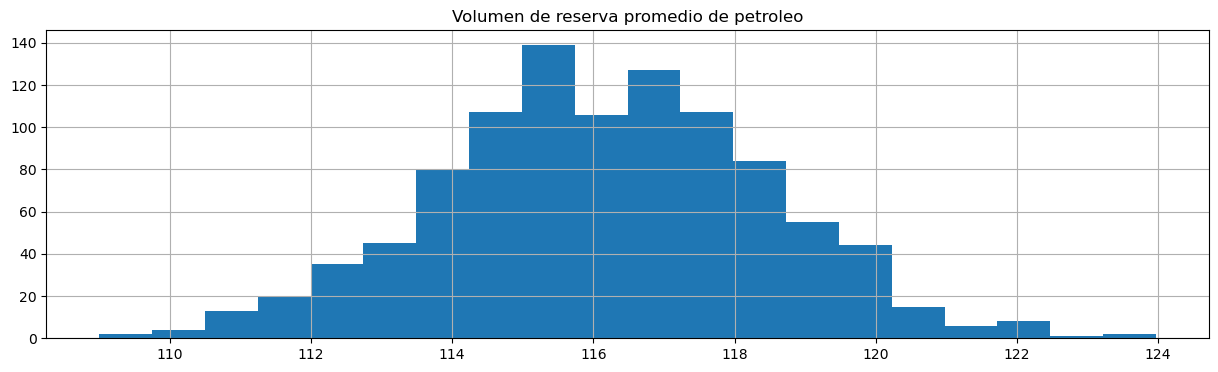

In [17]:
#transformamos las lista a dataframe para hacer los histograma
volumen_de_reserva_promedio = pd.Series(volumen_de_reserva_promedio)
volumen_de_reserva_promedio.hist(bins=20,figsize=(15,4))
plt.title('Volumen de reserva promedio de petroleo')
plt.show()

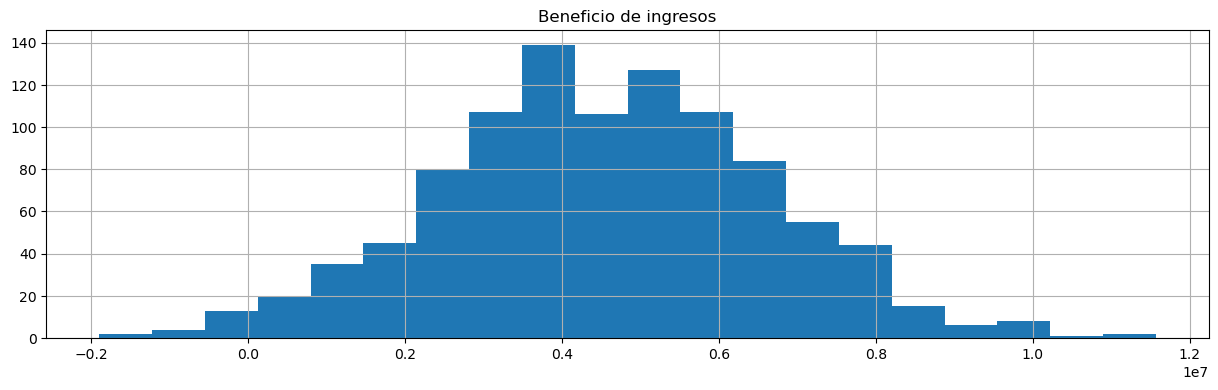

El beneficio promedio es de: 4,538,357.00


In [18]:
#transformamos las lista a dataframe para hacer los histograma
beneficio = pd.Series(beneficio)
#beneficio = pd.DataFrame(beneficio,columns=['beneficio'])
beneficio.hist(bins=20,figsize=(15,4))
plt.title('Beneficio de ingresos')
plt.show()
print('El beneficio promedio es de: {:,.2f}'.format(beneficio.mean()))

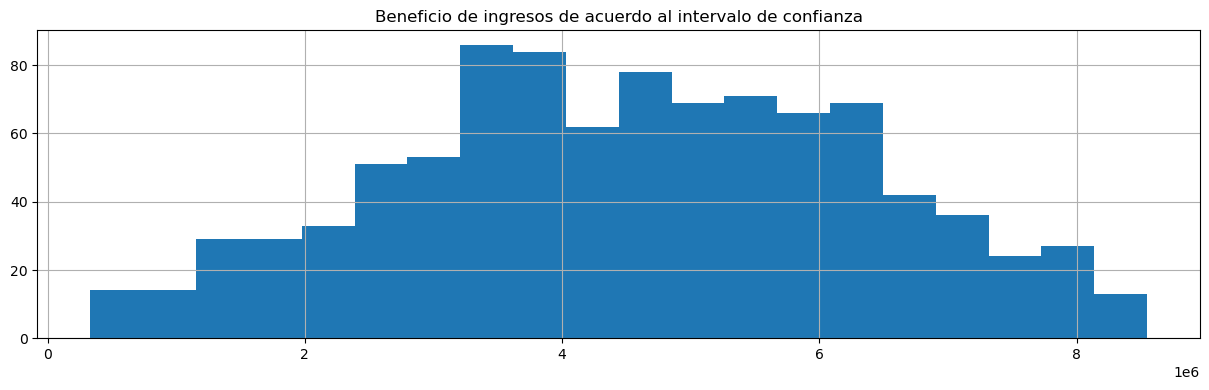

El beneficio promedio dentro del intervalo de confianza del 95% es de: 4,537,178.95


In [19]:
#transformamos las lista a dataframe para hacer los histograma
beneficio_1 = pd.DataFrame(beneficio,columns=['ganancia'])
beneficio_confianza = beneficio_1[(beneficio_1['ganancia'] >= lower) & (beneficio_1['ganancia'] <= upper)]
beneficio_confianza.hist(bins=20,figsize=(15,4))
plt.title('Beneficio de ingresos de acuerdo al intervalo de confianza')
plt.show()
print('El beneficio promedio dentro del intervalo de confianza del 95% es de: {:,.2f}'.format(beneficio_confianza['ganancia'].mean()))

Con el resultado anterior, podemos ver que las predicciones de los beneficio promedios es de 4,537,178.95 de USD y con el intervalo de confianza del 95%, no se dará el caso donde haya una perdida por la inversión.

In [20]:
riesgo = len(beneficio[beneficio<0])/len(beneficio)
print("El riesgo de excavar en esta región es de: {:.1%}" .format(riesgo))

El riesgo de excavar en esta región es de: 1.6%


## Conclusión <a class="anchor" id="Capítulo_5"></a>

Se encontró que de las tres regiones analizadas, la región 1 es la que da una mejor fiabilidad para hacer la extracción de petroleo en 200 pozos, dado su bajo RECM y también a que se predice un mayor voluemn de reservas.

Dada la inversión de 100 millones de USD, se espera que en promedio la ganancia por pozo sea 4,537,178.95 de USD con un riesgo del 1.6%, lo cual le puede dar mucha confianza a la empresa `Oily Giant` de relizar su extración en la región 1. 